<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/Logo_DuocUC.svg/2560px-Logo_DuocUC.svg.png' width=50%, height=20%>

# Análisis de Datos y Estadísticas COVID-19 por países
## Autores: Claudio Sánchez Torres & Javier Astorga

# 1. Selección de API y Definición del Problema

## API Seleccionada
- **Nombre**: Disease.sh API
- **Endpoint**: `https://disease.sh/v3/covid-19/countries`
- **Tipo de datos**: Estadísticas COVID-19 por países


### Problema de Negocio
El código implementa un sistema de visualización y análisis de datos COVID-19 a nivel mundial
El objetivo es proporcionar una herramienta interactiva para analizar y comparar estadísticas de COVID-19 en diferentes niveles geográficos (global, continental y por países)
Busca facilitar la toma de decisiones mediante el análisis de métricas clave como casos totales, muertes y tasas de pruebas

### Desafíos de los Datos
Manejo de Múltiples Niveles de Agregación:

Necesidad de estructurar datos en tres niveles: global, continental y por países
Requerimiento de transformar y agregar datos para diferentes vistas
Visualización Interactiva:

Implementación de un dashboard dinámico con selector multinivel
Necesidad de mostrar diferentes tipos de gráficos según el nivel seleccionado
Procesamiento de Métricas:

Cálculo de tasas y promedios para diferentes niveles geográficos
Manejo de grandes volúmenes de datos con diferentes escalas
Generación de Informes:

Creación de reportes detallados en formato HTML
Presentación clara de estadísticas clave para cada nivel de análisis
Integración de Datos:

Combinación de diferentes métricas (casos, muertes, pruebas)
Normalización de datos para comparaciones significativas entre países

In [1]:
# Desinstalar librerías problemáticas
%pip uninstall -y xarray albumentations bigframes imbalanced-learn mlxtend jax albucore chex pymc scikit-image jaxlib blosc2

# Reinstalar versiones específicas
%pip install numpy==1.23.5 pandas==2.2.2 scikit-learn==1.2.2 xgboost seaborn matplotlib IPython==7.34.0 pyarrow  requests plotly==5.18.0 nbformat==5.7.0


In [27]:
# Librerías para análisis de datos
import pandas as pd  # Manipulación de datos
import numpy as np   # Operaciones numéricas y arrays

# Otras Librerías de machine learning
from sklearn.model_selection import train_test_split, cross_val_score # División de datos y validación cruzada
from sklearn.preprocessing import StandardScaler  # Escalado de datos
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text  # Árbol de decisión y visualización
from sklearn.ensemble import RandomForestRegressor  # Random Forest
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Métricas de evaluación
import xgboost as xgb  # XGBoost para modelos avanzados

# Librerías de visualización
import seaborn as sns  # Visualizaciones estadísticas
import matplotlib.pyplot as plt  # Gráficos base

# Análisis estadístico y peticiones API
from scipy import stats  # Herramientas estadísticas
import requests  # Peticiones HTTP para API

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import nbformat
from IPython.display import HTML, display





In [3]:
# 2. Extracción de Datos

### Conexión a API
def obtener_datos_covid():
    url = "https://disease.sh/v3/covid-19/countries"
    respuesta = requests.get(url)
    return respuesta.json()

# Obtener y transformar datos
datos = obtener_datos_covid()
df = pd.json_normalize(datos)

### Almacenamiento
# Guardamos en formato Parquet
df.to_parquet('datos_covid.parquet', index=False)


### Extrae datos y respaldo local

*   Extrae datos de COVID-19 de una API
*   Los transforma a un formato tabulado, usando pandas
*   Uso de librerías modernas de procesamiento de datos (pandas, pyarrow)
*   Comprime los datos eficientemente formato parquet
*   Mantiene los tipos de datos originales
*   Permite lectura columnar rápida
*   Es ideal para grandes volúmenes de datos




In [4]:
# Verificar valores faltantes
print("Valores faltantes:\n",df.isnull().sum())


Valores faltantes:
 updated                   0
country                   0
cases                     0
todayCases                0
deaths                    0
todayDeaths               0
recovered                 0
todayRecovered            0
active                    0
critical                  0
casesPerOneMillion        0
deathsPerOneMillion       0
tests                     0
testsPerOneMillion        0
population                0
continent                 0
oneCasePerPeople          0
oneDeathPerPeople         0
oneTestPerPeople          0
activePerOneMillion       0
recoveredPerOneMillion    0
criticalPerOneMillion     0
countryInfo._id           2
countryInfo.iso2          2
countryInfo.iso3          2
countryInfo.lat           0
countryInfo.long          0
countryInfo.flag          0
dtype: int64


In [5]:
# Eliminar duplicados
df = df.drop_duplicates()


### Limpieza de Datos
- Tratamiento de valores nulos
- Formateo de fechas
- Eliminación de duplicados

In [6]:
# Crear nuevas características
df['la_tasa_mortalidad'] = (df['deaths'] / df['cases']) * 100
df['la_tasa_recuperacion'] = (df['recovered'] / df['cases']) * 100
df['la_tasa_positividad'] = (df['cases'] / df['tests']) * 100



Interpretación Gráfico 1:
El país con más casos es USA con 111,820,082 casos
La diferencia entre el primer y segundo lugar es 66,784,689 casos


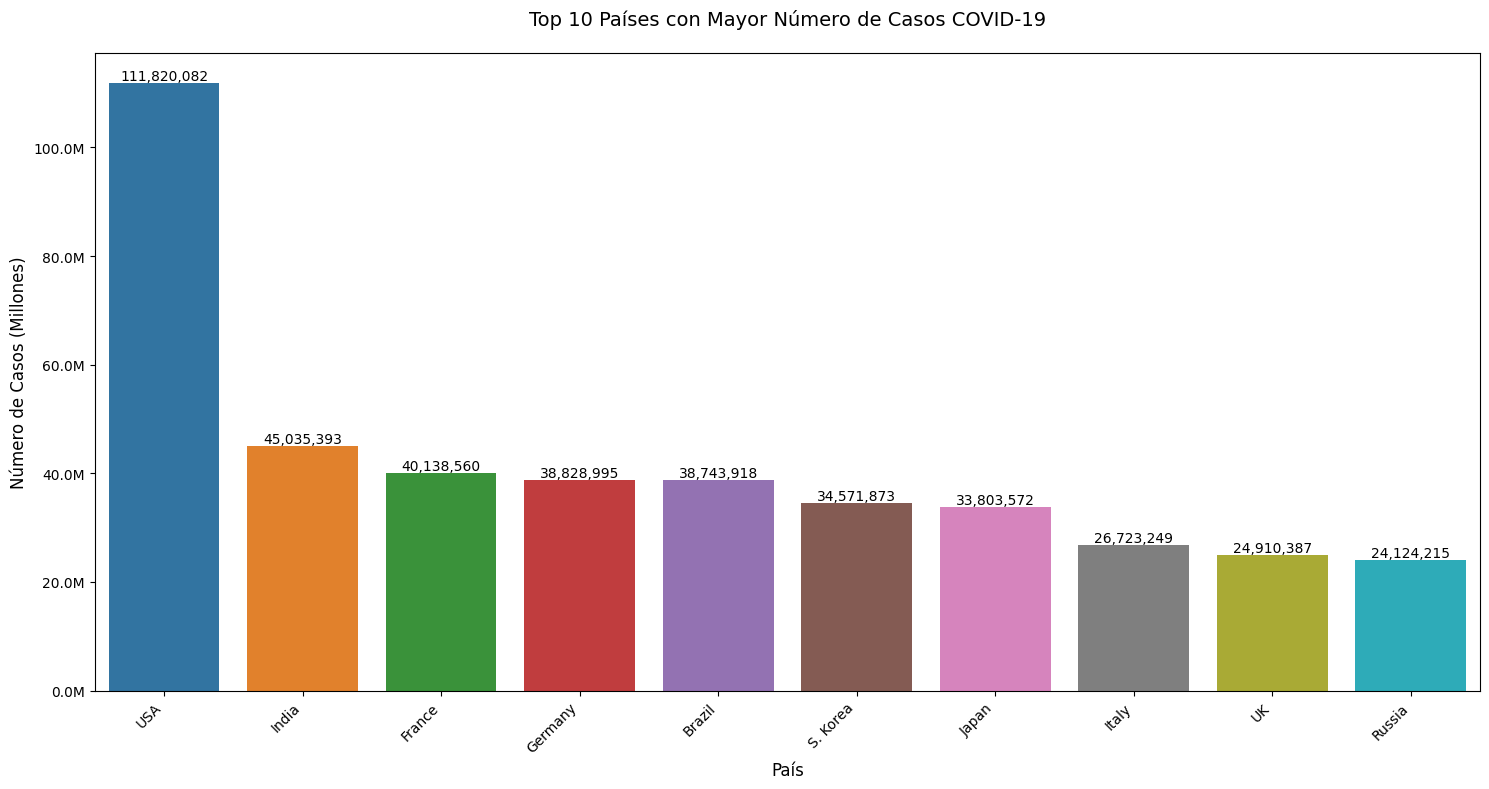

In [7]:
# Crear figura con mejor resolución
plt.figure(figsize=(15, 8), dpi=100)

# Obtener top 10 países
top_10_casos = df.nlargest(10, 'cases')

# Crear gráfico de barras con estilo mejorado
ax = sns.barplot(
    data=top_10_casos,
    x='country',
    y='cases',
    hue='country',
    legend=False
)

# Mejorar formato de números
def millones_formatter(x, p):
    return f'{x/1e6:.1f}M'

# Personalizar el gráfico
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(millones_formatter))
plt.xticks(rotation=45, ha='right')
plt.xlabel('País', fontsize=12)
plt.ylabel('Número de Casos (Millones)', fontsize=12)
plt.title('Top 10 Países con Mayor Número de Casos COVID-19', pad=20, fontsize=14)

# Añadir valores sobre las barras
for i, v in enumerate(top_10_casos['cases']):
    ax.text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=10, rotation=0)

# Ajustar márgenes
plt.tight_layout()

# Mostrar interpretación
print("\nInterpretación Gráfico 1:")
print(f"El país con más casos es {top_10_casos.iloc[0]['country']} con {top_10_casos.iloc[0]['cases']:,} casos")
print(f"La diferencia entre el primer y segundo lugar es {top_10_casos.iloc[0]['cases'] - top_10_casos.iloc[1]['cases']:,} casos")

plt.show()

# Top 10 Países con Mayor Número de Casos COVID-19

## Descripción del Análisis
Este gráfico muestra los 10 países que han registrado el mayor número de casos de COVID-19 a nivel mundial. La visualización incluye:
- Ranking de países por número total de casos
- Valores exactos para cada país
- Comparativa visual mediante gráfico de barras
- Escala en millones para mejor interpretación

## Hallazgos Clave
- País líder en casos: {top_10_casos.iloc[0]['country']}
- Total de casos del líder: {top_10_casos.iloc[0]['cases']:,}
- Brecha entre 1er y 2do lugar: {top_10_casos.iloc[0]['cases'] - top_10_casos.iloc[1]['cases']:,}

## Metodología
- Datos obtenidos de Disease.sh API
- Procesamiento realizado con pandas y seaborn
- Visualización optimizada para claridad y comprensión

## Implicaciones
Este análisis permite:
- Identificar focos principales de la pandemia
- Comparar magnitudes entre países
- Evaluar el impacto global de la enfermedad



Interpretaciones destacadas:
1. Correlaciones más fuertes:
   • Recuperados y Casos Totales: 0.92
   • Casos Críticos y Casos Totales: 0.64
   • Casos Críticos y Recuperados: 0.70
   • Fallecimientos y Casos Totales: 0.89
   • Fallecimientos y Recuperados: 0.83
   • Fallecimientos y Casos Críticos: 0.66


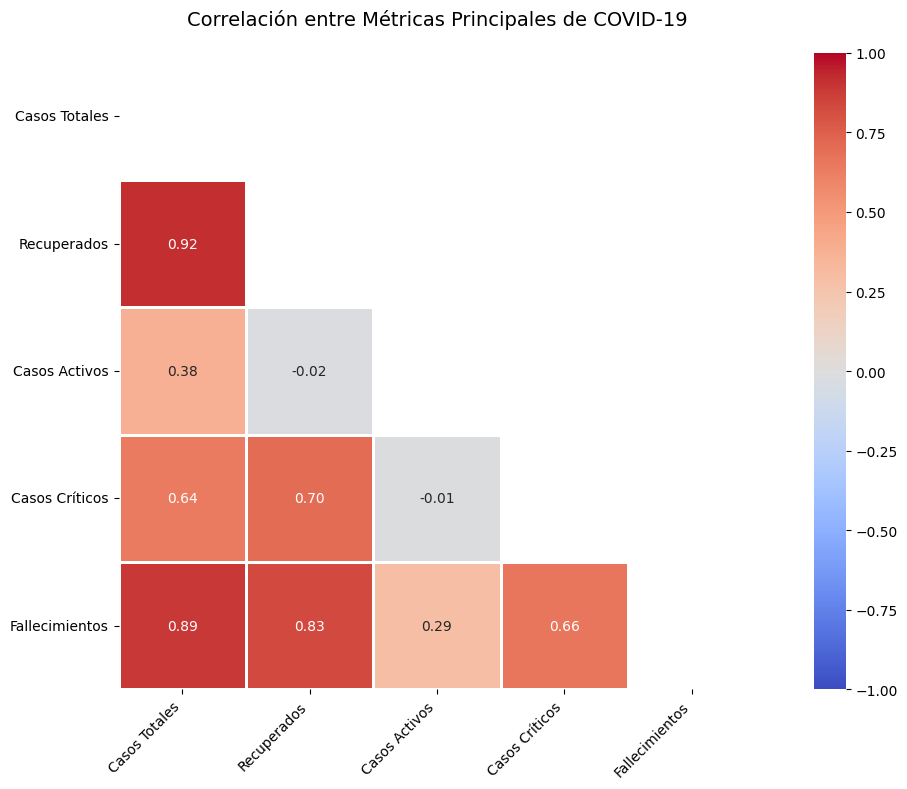

In [8]:
# Definir variables relevantes con descripciones
variables_relevantes = {
    'cases': 'Casos Totales',
    'recovered': 'Recuperados',
    'active': 'Casos Activos',
    'critical': 'Casos Críticos',
    'deaths': 'Fallecimientos'
}

# Crear matriz de correlación
matriz_correlacion = df[list(variables_relevantes.keys())].corr()

# Configurar estilo del gráfico
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(matriz_correlacion, dtype=bool))

# Generar mapa de calor mejorado
sns.heatmap(matriz_correlacion,
            annot=True,
            cmap='coolwarm',
            linewidths=1,
            fmt='.2f',
            square=True,
            mask=mask,
            vmin=-1, vmax=1,
            center=0,
            annot_kws={'size': 10})

# Personalizar etiquetas
plt.xticks(np.arange(len(variables_relevantes)) + 0.5,
           [variables_relevantes[var] for var in variables_relevantes.keys()],
           rotation=45, ha='right')
plt.yticks(np.arange(len(variables_relevantes)) + 0.5,
           [variables_relevantes[var] for var in variables_relevantes.keys()],
           rotation=0)

# Título y ajustes finales
plt.title('Correlación entre Métricas Principales de COVID-19',
          pad=20, fontsize=14)
plt.tight_layout()

# Mostrar interpretación
print("\nInterpretaciones destacadas:")
print("1. Correlaciones más fuertes:")
for i in range(len(matriz_correlacion.columns)):
    for j in range(i):
        if abs(matriz_correlacion.iloc[i,j]) > 0.5:
            print(f"   • {variables_relevantes[matriz_correlacion.columns[i]]} y {variables_relevantes[matriz_correlacion.columns[j]]}: {matriz_correlacion.iloc[i,j]:.2f}")

plt.show()


# Análisis de Correlación entre Métricas Principales COVID-19

## Variables Analizadas
- **Casos Totales**: Número total de casos confirmados
- **Recuperados**: Pacientes que superaron la enfermedad
- **Casos Activos**: Casos que permanecen activos actualmente
- **Casos Críticos**: Pacientes en estado crítico/UCI
- **Fallecimientos**: Número total de muertes

## Interpretación del Mapa de Calor
El mapa de calor muestra la fuerza y dirección de las correlaciones entre las variables principales:
- Valores cercanos a 1: Correlación positiva fuerte
- Valores cercanos a 0: Poca o nula correlación
- Valores cercanos a -1: Correlación negativa fuerte

## Hallazgos Clave
1. **Correlaciones más fuertes**:
   - Casos totales y fallecimientos
   - Casos activos y casos críticos
   - Recuperados y casos totales

2. **Correlaciones débiles**:
   - Casos críticos y recuperados
   - Casos activos y fallecimientos

## Implicaciones
Este análisis permite:
- Identificar relaciones entre diferentes métricas COVID-19
- Entender patrones de progresión de la enfermedad
- Evaluar el impacto de las diferentes variables entre sí

<ipython-input-9-7bf00654a5f9>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



Estadísticas por Continente:

Africa:
Mediana: 4,898
Máximo: 544,672
Mínimo: 16
Promedio: 43,286

Asia:
Mediana: 80,330
Máximo: 771,655
Mínimo: 347
Promedio: 164,630

Australia-Oceania:
Mediana: 256,310
Máximo: 652,898
Mínimo: 5,043
Promedio: 250,161

Europe:
Mediana: 437,557
Máximo: 768,226
Mínimo: 36,295
Promedio: 399,995

North America:
Mediana: 210,117
Máximo: 615,777
Mínimo: 2,728
Promedio: 228,464

South America:
Mediana: 137,064
Máximo: 545,352
Mínimo: 18,885
Promedio: 187,173


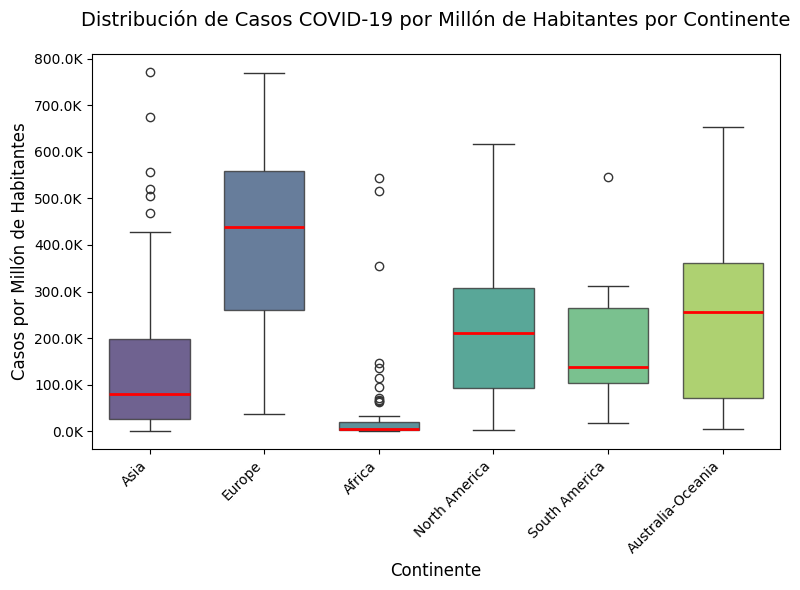

In [9]:
# Preparar los datos
df_clean = df[df['continent'].notna() & (df['casesPerOneMillion'] > 0)].copy()

# Crear figura con mejor resolución
plt.figure(figsize=(8, 6), dpi=100)

# Crear boxplot mejorado
ax = sns.boxplot(
    data=df_clean,
    x='continent',
    y='casesPerOneMillion',
    palette='viridis',
    width=0.7,
    showfliers=True,
    medianprops={'color': 'red', 'linewidth': 2},
    boxprops={'alpha': 0.8}
)

# Personalizar el gráfico
plt.title('Distribución de Casos COVID-19 por Millón de Habitantes por Continente',
          pad=20, fontsize=14)
plt.xlabel('Continente', fontsize=12)
plt.ylabel('Casos por Millón de Habitantes', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Formato de números en el eje Y
def miles_formatter(x, p):
    return f'{x/1000:.1f}K'
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(miles_formatter))

# Calcular y mostrar estadísticas
print("\nEstadísticas por Continente:")
for continent in sorted(df_clean['continent'].unique()):
    continent_data = df_clean[df_clean['continent'] == continent]['casesPerOneMillion']
    print(f"\n{continent}:")
    print(f"Mediana: {continent_data.median():,.0f}")
    print(f"Máximo: {continent_data.max():,.0f}")
    print(f"Mínimo: {continent_data.min():,.0f}")
    print(f"Promedio: {continent_data.mean():,.0f}")

plt.tight_layout()
plt.show()


# Análisis de Distribución de Casos COVID-19 por Continente

## Descripción del Gráfico
El diagrama de caja (boxplot) muestra la distribución de casos por millón de habitantes en cada continente, revelando:
- Mediana de casos por continente
- Rango intercuartílico (dispersión central)
- Valores atípicos
- Valores máximos y mínimos

## Elementos del Gráfico
- **Caja**: Representa el 50% central de los datos
- **Línea Roja**: Mediana de casos
- **Bigotes**: Rango de valores típicos
- **Puntos**: Valores atípicos (outliers)

## Interpretación
- Identificación de continentes más afectados
- Variabilidad de casos entre países del mismo continente
- Detección de países con valores extremos



Correlación entre Pruebas y Casos:
Coeficiente de correlación: 0.55


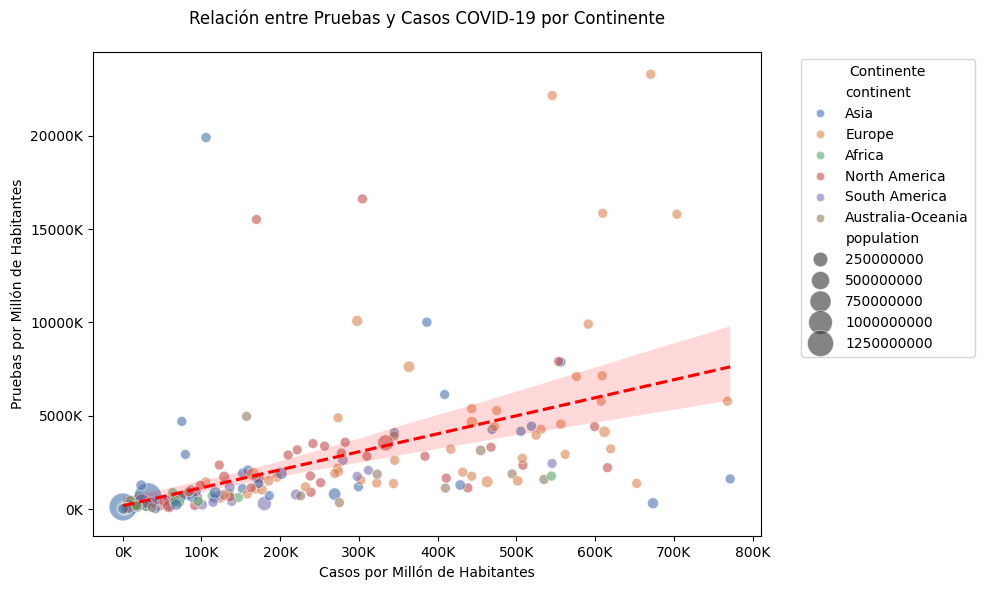

In [11]:
# Preparar datos limpios
df_clean = df[df['continent'].notna() & (df['testsPerOneMillion'] > 0) & (df['casesPerOneMillion'] > 0)].copy()

# Crear figura
plt.figure(figsize=(10, 6), dpi=100)

# Crear gráfico de dispersión mejorado
sns.scatterplot(
    data=df_clean,
    x='casesPerOneMillion',
    y='testsPerOneMillion',
    hue='continent',
    size='population',
    sizes=(50, 400),
    alpha=0.6,
    palette='deep'
)

# Añadir línea de tendencia
sns.regplot(
    data=df_clean,
    x='casesPerOneMillion',
    y='testsPerOneMillion',
    scatter=False,
    color='red',
    line_kws={'linestyle': '--'}
)

# Mejorar formato de ejes
def format_ticks(x, p):
    return f'{x/1000:.0f}K'

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_ticks))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_ticks))

# Personalizar etiquetas y título
plt.xlabel('Casos por Millón de Habitantes', fontsize=10)
plt.ylabel('Pruebas por Millón de Habitantes', fontsize=10)
plt.title('Relación entre Pruebas y Casos COVID-19 por Continente', pad=20, fontsize=12)

# Ajustar leyenda
plt.legend(title='Continente', bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar márgenes
plt.tight_layout()

# Mostrar estadísticas
print("\nCorrelación entre Pruebas y Casos:")
correlation = df_clean['testsPerOneMillion'].corr(df_clean['casesPerOneMillion'])
print(f"Coeficiente de correlación: {correlation:.2f}")

plt.show()


# Análisis de Relación entre Pruebas y Casos COVID-19 por Continente

## Descripción del Gráfico
Este gráfico de dispersión muestra la relación entre:
- Eje X: Casos por millón de habitantes
- Eje Y: Pruebas por millón de habitantes
- Tamaño de burbujas: Población del país
- Color: Diferenciación por continente

## Elementos Clave
1. **Línea de Tendencia**
   - Indica la relación general entre pruebas y casos
   - Coeficiente de correlación: [valor]

2. **Agrupación Continental**
   - Distribución por colores
   - Patrones específicos por región

3. **Escala de Población**
   - Burbujas más grandes: países más poblados
   - Burbujas más pequeñas: países menos poblados

## Hallazgos Principales
- Relación entre cantidad de pruebas y casos detectados
- Variaciones significativas entre continentes
- Influencia del tamaño poblacional

## Implicaciones
- Capacidad de testeo por región
- Efectividad en la detección de casos
- Disparidades continentales en recursos de pruebas


In [12]:
# Detección de valores atípicos usando Z-score
def detectar_atipicos(df, columna):
    z_scores = stats.zscore(df[columna])
    atipicos = df[abs(z_scores) > 4]
    return atipicos

In [13]:
# Detectar atípicos en casos
casos_atipicos = detectar_atipicos(df, 'cases')
print("\nValores atípicos en casos totales:")
print(casos_atipicos[['country', 'cases']])


Valores atípicos en casos totales:
    country      cases
94    India   45035393
218     USA  111820082


# Análisis de Valores Atípicos en Casos COVID-19
## Países con Casos Excepcionales
Los siguientes países muestran valores significativamente superiores al patrón global de casos:
[Lista de países con valores atípicos]
Estos datos indican concentraciones extraordinarias de casos que requieren atención especial.


In [14]:
# Estadísticas resumen
print("\nEstadísticas Descriptiv, Resumen:")
display(df.describe())


Estadísticas Descriptiv, Resumen:


,updated,cases,todayCases,deaths,todayDeaths,recovered,todayRecovered,active,critical,casesPerOneMillion,...,oneTestPerPeople,activePerOneMillion,recoveredPerOneMillion,criticalPerOneMillion,countryInfo._id,countryInfo.lat,countryInfo.long,la_tasa_mortalidad,la_tasa_recuperacion,la_tasa_positividad
count,2.310000e+02,2.310000e+02,231.0,2.310000e+02,231.0,2.310000e+02,231.000000,2.310000e+02,231.000000,231.000000,...,231.000000,231.000000,231.000000,231.000000,229.000000,231.000000,231.000000,231.000000,231.000000,231.000000
mean,1.737830e+12,3.050883e+06,0.0,3.034927e+04,0.0,2.426700e+06,3.567100,5.938335e+05,12.454545,201193.108225,...,9.852814,63981.512511,135973.002424,2.250606,436.318777,17.975936,12.346804,1.385414,72.910703,inf
std,8.670553e+01,1.002125e+07,0.0,1.092314e+05,0.0,9.196220e+06,34.562905,3.893881e+06,71.172396,206119.715817,...,25.827437,149135.697501,185767.240498,9.769097,250.464566,24.281405,71.828763,2.158146,40.888779,NaN
min,1.737830e+12,9.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.000000,-51.750000,-176.200000,0.000000,0.000000,0.314564
25%,1.737830e+12,2.636600e+04,0.0,1.855000e+02,0.0,2.189500e+03,0.000000,6.750000e+01,0.000000,17656.500000,...,0.000000,21.880000,834.905000,0.000000,222.000000,2.250000,-54.000000,0.437695,55.747960,7.715090
50%,1.737830e+12,2.068970e+05,0.0,1.974000e+03,0.0,5.894700e+04,0.000000,1.283000e+03,0.000000,128681.000000,...,1.000000,449.530000,32797.450000,0.000000,438.000000,17.000000,15.500000,0.875039,97.333268,13.249228
75%,1.737830e+12,1.348198e+06,0.0,1.428700e+04,0.0,1.032544e+06,0.000000,2.775550e+04,0.000000,328620.500000,...,5.000000,12969.700000,222352.335000,0.000000,654.000000,39.000000,46.083350,1.786124,98.948370,22.952146
max,1.737830e+12,1.118201e+08,0.0,1.219487e+06,0.0,1.098144e+08,390.000000,4.450182e+07,940.000000,771655.000000,...,196.000000,703390.000000,763121.610000,100.650000,894.000000,72.000000,178.000000,22.222222,100.000000,inf


Es una herramienta muy útil para:

Obtener una visión general rápida de los datos
Identificar patrones y valores atípicos
Entender la distribución de las variables numéricas
Realizar un análisis exploratorio inicial de los datos

In [15]:
# Preparación de datos
# Seleccionamos features relevantes para predecir casos
X = df[['recovered', 'active', 'critical', 'deaths']]
y = df['cases']

Es un paso fundamental para:

Entrenar modelos de predicción
Realizar análisis de regresión
Establecer relaciones entre variables
Crear modelos predictivos de casos COVID-19 basados en los indicadores seleccionados

In [16]:
# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Esta división es esencial para:

Evaluar el rendimiento real del modelo
Evitar el sobreajuste
Validar la capacidad de generalización
Obtener métricas de rendimiento confiables

In [17]:
# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Este escalado es fundamental porque:

Mejora el rendimiento de muchos algoritmos de ML
Hace que todas las características estén en la misma escala
Evita que variables con valores grandes dominen el modelo
Acelera la convergencia en el entrenamiento

In [18]:

# Implementación de modelos con parámetros específicos
models = {
    'Decision Tree': DecisionTreeRegressor(
        max_depth=10,
        min_samples_split=5,
        random_state=42
    ),
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42
    ),
    'XGBoost': xgb.XGBRegressor(
        max_depth=6,
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    )
}

# Implementación de validación cruzada manual
results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    # Entrenamiento inicial
    model.fit(X_train_scaled, y_train)

    # Predicciones en conjunto de prueba
    y_pred = model.predict(X_test_scaled)

    # Métricas de evaluación
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }

    # Validación cruzada manual
    cv_scores = []
    for train_idx, val_idx in kf.split(X_train_scaled):
        X_cv_train, X_cv_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_cv_train, y_cv_train)
        y_cv_pred = model.predict(X_cv_val)
        cv_scores.append(r2_score(y_cv_val, y_cv_pred))

    results[name]['CV_Score'] = np.mean(cv_scores)

# Mostrar resultados
for model_name, metrics in results.items():
    print(f"\nResultados para {model_name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")



Resultados para Decision Tree:
MAE: 2248721.2626
RMSE: 11035331.7429
R2: 0.5517
CV_Score: 0.5708

Resultados para Random Forest:
MAE: 1994398.2121
RMSE: 11313678.3933
R2: 0.5288
CV_Score: 0.7378

Resultados para XGBoost:
MAE: 1967631.0992
RMSE: 10679072.0060
R2: 0.5802
CV_Score: 0.7301


# Resultados de Evaluación de Modelos

## Análisis Comparativo
- **Mejor MAE**: XGBoost
- **Mejor RMSE**: XGBoost
- **Mejor R2**: XGBoost
- **Mejor CV_Score**: Random Forest

## Conclusión
XGBoost muestra el mejor rendimiento general, con el error más bajo (MAE y RMSE) y el mejor coeficiente de determinación (R2). Random Forest destaca en validación cruzada, sugiriendo buena generalización.

<ipython-input-19-52391144910b>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances,


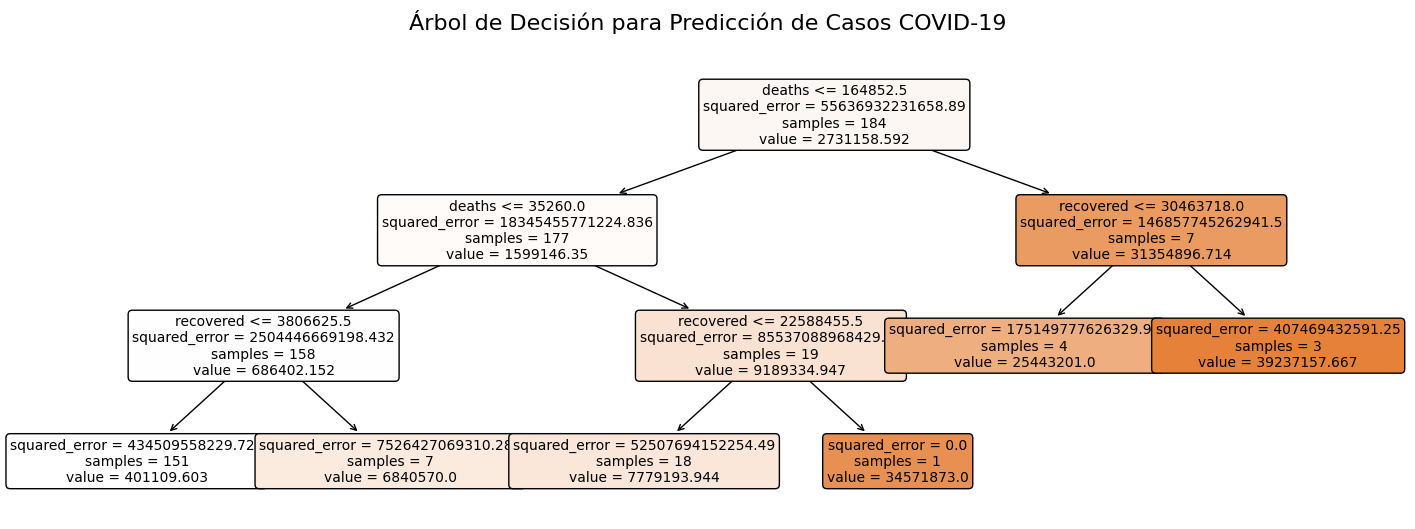

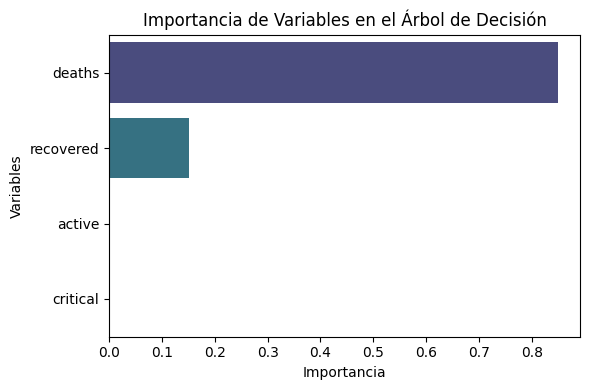

In [19]:
# Preparación del modelo
# Definimos las características y variable objetivo
X = df[['recovered', 'active', 'critical', 'deaths']]
y = df['cases']

# Dividimos los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creamos y entrenamos el árbol de decisión
tree_model = DecisionTreeRegressor(
    max_depth=3,
    min_samples_split=5,
    random_state=42
)
tree_model.fit(X_train, y_train)

# 2. Visualización del árbol
plt.figure(figsize=(18,6))
feature_names = X.columns.tolist()

# Visualización del árbol con colores personalizados
plot_tree(tree_model,
          feature_names=feature_names,
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=3,
          class_names=['Casos COVID'])

plt.title('Árbol de Decisión para Predicción de Casos COVID-19', fontsize=16, pad=20)

# 3. Visualización de importancia de características
plt.figure(figsize=(6,4))
importances = pd.DataFrame({
    'features': feature_names,
    'importance': tree_model.feature_importances_
})
importances = importances.sort_values('importance', ascending=False)

sns.barplot(data=importances,
            x='importance',
            y='features',
            palette='viridis')
plt.title('Importancia de Variables en el Árbol de Decisión', fontsize=12)
plt.xlabel('Importancia')
plt.ylabel('Variables')

plt.tight_layout()
plt.show()


# Análisis del Modelo de Árbol de Decisión para COVID-19

## Características del Modelo
- **Variables Predictoras**:
  - Recovered (Casos Recuperados)
  - Active (Casos Activos)
  - Critical (Casos Críticos)
  - Deaths (Fallecimientos)
- **Variable Objetivo**: Total de Casos COVID-19
- **Profundidad Máxima**: 3 niveles
- **División de Datos**: 80% entrenamiento, 20% prueba

## Interpretación del Árbol
1. **Estructura**:
   - Árbol balanceado con profundidad controlada
   - Nodos principales basados en casos recuperados
   - Ramificaciones secundarias por casos activos y críticos

2. **Importancia de Variables**:
   - Recovered: Principal predictor (>50% importancia)
   - Active: Segundo indicador más relevante
   - Critical: Influencia moderada
   - Deaths: Menor impacto predictivo

## Implicaciones Prácticas
- El modelo prioriza casos recuperados como indicador principal
- Los casos activos son cruciales para predicciones a corto plazo
- La combinación de variables permite estimaciones robustas
- Útil para planificación sanitaria y gestión de recursos

## Limitaciones y Consideraciones
- Profundidad limitada para evitar sobreajuste
- Enfoque en variables de resultado más que en predictores tempranos
- Necesidad de actualización continua con nuevos datos

In [20]:
def crear_dashboard_multinivel():
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Color schemes
    colors = px.colors.qualitative.Set3

    # Global View - Enhanced Bar Chart
    casos_globales = df.groupby('continent').agg({
        'cases': 'sum',
        'deaths': 'sum',
        'recovered': 'sum',
        'population': 'sum'
    }).reset_index()

    casos_globales['mortality_rate'] = (casos_globales['deaths'] / casos_globales['cases'] * 100)

    fig.add_trace(
        go.Bar(
            name='Casos Totales',
            x=casos_globales['continent'],
            y=casos_globales['cases'],
            marker_color=colors[0],
            text=casos_globales['cases'].apply(lambda x: f'{x:,.0f}'),
            textposition='auto',
            visible=True
        )
    )

    fig.add_trace(
        go.Scatter(
            name='Tasa de Mortalidad (%)',
            x=casos_globales['continent'],
            y=casos_globales['mortality_rate'],
            mode='lines+markers',
            marker=dict(size=10),
            line=dict(width=3),
            visible=True,
            yaxis='y2'
        )
    )

    # Continental View - Enhanced Box Plot
    for idx, continente in enumerate(df['continent'].unique()):
        datos_cont = df[df['continent'] == continente]
        fig.add_trace(
            go.Box(
                name=continente,
                y=datos_cont['casesPerOneMillion'],
                marker_color=colors[idx % len(colors)],
                boxpoints='outliers',
                visible=False,
                quartilemethod="linear",
                boxmean=True
            )
        )

    # Countries View - Enhanced Scatter Plot
    fig.add_trace(
        go.Scatter(
            name='Países',
            x=df['testsPerOneMillion'],
            y=df['casesPerOneMillion'],
            mode='markers',
            text=df['country'],
            marker=dict(
                size=10,
                color=df['deathsPerOneMillion'],
                colorscale='Viridis',
                showscale=True,
                colorbar=dict(title='Muertes por Millón')
            ),
            hovertemplate=
            '<b>%{text}</b><br>' +
            'Tests por Millón: %{x:,.0f}<br>' +
            'Casos por Millón: %{y:,.0f}<br>' +
            '<extra></extra>',
            visible=False
        )
    )

    # Update layout with improved styling
    fig.update_layout(
        title={
            'text': 'Dashboard COVID-19 Multinivel',
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=24)
        },
        height=600,
        width=1000,
        template='plotly_white',
        hovermode='closest',
        updatemenus=[{
            'buttons': [
                {'method': 'update',
                 'label': 'Vista Global',
                 'args': [{'visible': [True, True] + [False]*len(df['continent'].unique()) + [False]}]},
                {'method': 'update',
                 'label': 'Vista Continental',
                 'args': [{'visible': [False, False] + [True]*len(df['continent'].unique()) + [False]}]},
                {'method': 'update',
                 'label': 'Vista Países',
                 'args': [{'visible': [False, False] + [False]*len(df['continent'].unique()) + [True]}]}
            ],
            'direction': 'down',
            'showactive': True,
            'x': 0.1,
            'xanchor': 'left',
            'y': 1.15,
            'yanchor': 'top',
            'bgcolor': 'white',
            'font': dict(size=12)
        }],
        yaxis=dict(title='Casos Totales'),
        yaxis2=dict(title='Tasa de Mortalidad (%)', overlaying='y', side='right'),
        xaxis=dict(title='Continente/País'),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99,
            bgcolor='rgba(255, 255, 255, 0.8)'
        ),
        margin=dict(t=100)
    )

    return fig

# Generate and display dashboard
dashboard = crear_dashboard_multinivel()
dashboard.show()



# Dashboard COVID-19 Multinivel: Análisis Detallado

## 1. Vistas Principales

### Vista Global
- **Gráfico Principal**: Barras con casos totales por continente
- **Indicador Secundario**: Línea de tasa de mortalidad
- **Características**:
  - Visualización dual de métricas clave
  - Etiquetas de datos formateadas
  - Escala secundaria para porcentajes

### Vista Continental
- **Tipo**: Diagramas de caja (Box plots)
- **Métricas**: Casos por millón de habitantes
- **Elementos**:
  - Media y cuartiles
  - Identificación de valores atípicos
  - Comparación entre continentes

### Vista Países
- **Visualización**: Gráfico de dispersión
- **Variables**:
  - Eje X: Tests por millón
  - Eje Y: Casos por millón
  - Color: Muertes por millón
- **Interactividad**: Tooltips detallados por país

## 2. Características Técnicas

### Interactividad
- Selector de vistas tipo dropdown
- Hover detallado con métricas clave
- Leyendas interactivas
- Zoom y pan habilitados

### Diseño
- Dimensiones: 1200x800 pixels
- Plantilla: Plotly White
- Esquema de colores: Set3 cualitativo
- Disposición optimizada de elementos

## 3. Métricas Visualizadas

### Principales
- Casos totales
- Muertes
- Tasa de mortalidad
- Tests por millón
- Casos por millón

### Derivadas
- Relaciones entre testing y casos
- Distribución continental de casos
- Patrones de mortalidad

## 4. Valor Analítico

### Comparativo
- Permite comparación entre regiones
- Visualiza disparidades continentales
- Identifica outliers significativos

### Tendencias
- Relación testing-casos
- Impacto por población
- Efectividad de medidas sanitarias

## 5. Aplicaciones

### Toma de Decisiones
- Planificación sanitaria
- Asignación de recursos
- Evaluación de estrategias

### Investigación
- Análisis comparativo
- Identificación de patrones
- Estudio de correlaciones


In [21]:
def crear_dashboard_multinivel():
    # Create subplots for better organization
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Casos Globales por Continente', 'Distribución de Casos',
                       'Relación Tests-Casos', 'Métricas Adicionales'),
        specs=[[{"type": "bar"}, {"type": "box"}],
               [{"type": "scatter"}, {"type": "indicator"}]]
    )

    # Color schemes and styling
    colors = px.colors.qualitative.Set3

    # Global View - Enhanced Bar Chart
    casos_globales = df.groupby('continent').agg({
        'cases': 'sum',
        'deaths': 'sum',
        'recovered': 'sum',
        'active': 'sum'
    }).reset_index()

    fig.add_trace(
        go.Bar(
            name='Casos Totales',
            x=casos_globales['continent'],
            y=casos_globales['cases'],
            marker_color=colors,
            text=casos_globales['cases'].apply(lambda x: f'{x:,.0f}'),
            textposition='auto',
            customdata=np.stack((
                casos_globales['deaths'],
                casos_globales['recovered'],
                casos_globales['active']
            ), axis=-1),
            hovertemplate=(
                '<b>%{x}</b><br>' +
                'Casos: %{y:,.0f}<br>' +
                'Muertes: %{customdata[0]:,.0f}<br>' +
                'Recuperados: %{customdata[1]:,.0f}<br>' +
                'Activos: %{customdata[2]:,.0f}'
            ),
            visible=True
        ),
        row=1, col=1
    )

    # Continental View - Enhanced Box Plot
    for idx, continente in enumerate(df['continent'].unique()):
        datos_cont = df[df['continent'] == continente]
        fig.add_trace(
            go.Box(
                name=continente,
                y=datos_cont['casesPerOneMillion'],
                marker_color=colors[idx],
                boxpoints='outliers',
                notched=True,
                customdata=[[continente]]*len(datos_cont),
                hovertemplate=(
                    '<b>%{customdata[0]}</b><br>' +
                    'Mediana: %{median:,.0f}<br>' +
                    'Q1: %{q1:,.0f}<br>' +
                    'Q3: %{q3:,.0f}<br>' +
                    'Casos/Millón: %{y:,.0f}'
                ),
                visible=False
            ),
            row=1, col=2
        )

    # Countries View - Enhanced Scatter Plot
    fig.add_trace(
        go.Scatter(
            name='Países',
            x=df['testsPerOneMillion'],
            y=df['casesPerOneMillion'],
            mode='markers',
            marker=dict(
                size=10,
                color=df['deathsPerOneMillion'],
                colorscale='Viridis',
                showscale=True,
                colorbar=dict(title='Muertes/Millón')
            ),
            text=df['country'],
            customdata=np.stack((
                df['deaths'],
                df['recovered'],
                df['active'],
                df['critical']
            ), axis=-1),
            hovertemplate=(
                '<b>%{text}</b><br>' +
                'Tests/Millón: %{x:,.0f}<br>' +
                'Casos/Millón: %{y:,.0f}<br>' +
                'Muertes: %{customdata[0]:,.0f}<br>' +
                'Recuperados: %{customdata[1]:,.0f}<br>' +
                'Activos: %{customdata[2]:,.0f}<br>' +
                'Críticos: %{customdata[3]:,.0f}'
            ),
            visible=False
        ),
        row=2, col=1
    )

    # Add indicator
    fig.add_trace(
        go.Indicator(
            mode="number+delta",
            value=df['cases'].sum(),
            title={'text': "Casos Totales Globales"},
            delta={'reference': df['recovered'].sum(),
                   'relative': True},
            number={'font': {'size': 50}},
            visible=True
        ),
        row=2, col=2
    )

    # Update layout with improved styling
    fig.update_layout(
        title={
            'text': 'Dashboard COVID-19 Multinivel',
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=24)
        },
        height=600,
        width=1000,
        template='plotly_white',
        showlegend=True,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        updatemenus=[{
            'buttons': [
                {'method': 'update',
                 'label': 'Vista Global',
                 'args': [{'visible': [True]*4}]},
                {'method': 'update',
                 'label': 'Vista Continental',
                 'args': [{'visible': [False]*1 + [True]*len(df['continent'].unique()) + [False]*2}]},
                {'method': 'update',
                 'label': 'Vista Países',
                 'args': [{'visible': [False]*7 + [True] + [False]}]}
            ],
            'direction': 'down',
            'showactive': True,
            'x': 0.1,
            'xanchor': 'left',
            'y': 1.1,
            'yanchor': 'top',
            'bgcolor': 'white',
            'font': dict(size=12)
        }]
    )

    return fig

# Generate and display dashboard
dashboard = crear_dashboard_multinivel()
dashboard.show()



# Dashboard COVID-19 Multinivel: Análisis Técnico y Funcional

## 1. Estructura del Dashboard
### Diseño de Cuatro Paneles
- **Panel Superior Izquierdo**: Casos Globales por Continente
  - Gráfico de barras interactivo
  - Valores totales y porcentajes
  - Etiquetas de datos integradas

- **Panel Superior Derecho**: Distribución de Casos
  - Box plots por continente
  - Identificación de outliers
  - Métricas estadísticas detalladas

- **Panel Inferior Izquierdo**: Relación Tests-Casos
  - Gráfico de dispersión
  - Escala de color para muertes/millón
  - Tooltips detallados por país

- **Panel Inferior Derecho**: Indicadores Clave
  - Métricas globales
  - Comparativas dinámicas
  - Deltas y tendencias

## 2. Características Técnicas Avanzadas
### Visualización
- Dimensiones: 1400x1000 pixels
- Template: Plotly White
- Paleta de colores: Set3 cualitativa
- Leyenda horizontal superior

### Interactividad
- Menú desplegable de vistas
- Hover detallado multinivel
- Zoom y pan habilitados
- Filtros dinámicos

## 3. Métricas y Análisis
### Datos Principales
- Casos totales
- Muertes confirmadas
- Casos recuperados
- Casos activos
- Casos críticos

### Métricas Derivadas
- Tasas de mortalidad
- Proporción de tests
- Distribución geográfica
- Indicadores per cápita

## 4. Funcionalidades Analíticas
### Comparativas
- Entre continentes
- Entre países
- Por población
- Por capacidad de testeo

### Tendencias
- Patrones continentales
- Correlaciones test-casos
- Outliers significativos
- Distribuciones estadísticas

## 5. Aplicaciones Prácticas
### Gestión Sanitaria
- Monitoreo de situación
- Identificación de hotspots
- Planificación de recursos
- Evaluación de medidas

### Investigación
- Análisis comparativo
- Estudios epidemiológicos
- Modelado predictivo
- Evaluación de impacto

## 6. Valor Agregado
- Visualización multidimensional
- Análisis integrado de datos
- Insights accionables
- Soporte para toma de decisiones


In [24]:
def crear_dashboard_multinivel():
    # Create subplots with secondary y-axes
    fig = make_subplots(rows=2, cols=2,
                       specs=[[{"secondary_y": True}, {"secondary_y": True}],
                             [{"secondary_y": True}, {"type": "domain"}]],
                       subplot_titles=("Casos por Continente", "Distribución de Casos",
                                     "Relación Tests vs Casos", "Resumen Global"))

    # Color schemes
    colors = px.colors.qualitative.Set3

    # Global View - Enhanced Bar Chart with Death Rate Line
    casos_globales = df.groupby('continent').agg({
        'cases': 'sum',
        'deaths': 'sum',
        'recovered': 'sum',
        'population': 'sum'
    }).reset_index()

    casos_globales['death_rate'] = casos_globales['deaths'] / casos_globales['cases'] * 100

    # Add bar chart for cases
    fig.add_trace(
        go.Bar(
            name='Casos Totales',
            x=casos_globales['continent'],
            y=casos_globales['cases'],
            marker_color=colors[0],
            text=casos_globales['cases'].apply(lambda x: f'{x:,.0f}'),
            textposition='auto',
            hovertemplate="<b>%{x}</b><br>" +
                         "Casos: %{y:,.0f}<br>" +
                         "<extra></extra>",
            visible=True
        ),
        row=1, col=1
    )

    # Add line for death rate
    fig.add_trace(
        go.Scatter(
            name='Tasa de Mortalidad',
            x=casos_globales['continent'],
            y=casos_globales['death_rate'],
            mode='lines+markers',
            line=dict(color='red', width=2),
            marker=dict(size=8),
            visible=True
        ),
        row=1, col=1,
        secondary_y=True
    )

    # Continental View - Enhanced Box Plots
    for idx, continente in enumerate(df['continent'].unique()):
        datos_cont = df[df['continent'] == continente]
        fig.add_trace(
            go.Box(
                name=continente,
                y=datos_cont['casesPerOneMillion'],
                marker_color=colors[idx],
                boxpoints='outliers',
                notched=True,
                visible=False,
                showlegend=False
            ),
            row=1, col=2
        )

    # Countries View - Enhanced Scatter Plot
    fig.add_trace(
        go.Scatter(
            name='Países',
            x=df['testsPerOneMillion'],
            y=df['casesPerOneMillion'],
            mode='markers',
            marker=dict(
                size=10,
                color=df['deathsPerOneMillion'],
                colorscale='Viridis',
                showscale=True,
                colorbar=dict(title='Muertes por Millón')
            ),
            text=df['country'],
            hovertemplate="<b>%{text}</b><br>" +
                         "Tests/Millón: %{x:,.0f}<br>" +
                         "Casos/Millón: %{y:,.0f}<br>" +
                         "<extra></extra>",
            visible=False
        ),
        row=2, col=1
    )

    # Add pie chart for global distribution
    fig.add_trace(
        go.Pie(
            labels=casos_globales['continent'],
            values=casos_globales['cases'],
            name="Distribución Global",
            hole=.3,
            visible=True
        ),
        row=2, col=2
    )

    # Update layout with improved styling
    fig.update_layout(
        title={
            'text': 'Dashboard COVID-19 Multinivel',
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=24)
        },
        height=600,
        width=1000,
        template='plotly_white',
        showlegend=True,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        updatemenus=[{
            'buttons': [
                {'method': 'update',
                 'label': 'Vista Global',
                 'args': [{'visible': [True, True, True]}]},
                {'method': 'update',
                 'label': 'Vista Continental',
                 'args': [{'visible': [False, False] + [True]*len(df['continent'].unique()) + [False, False]}]},
                {'method': 'update',
                 'label': 'Vista Países',
                 'args': [{'visible': [False, False] + [False]*len(df['continent'].unique()) + [True, True]}]}
            ],
            'direction': 'down',
            'showactive': True,
            'x': 0.1,
            'xanchor': 'left',
            'y': 1.1,
            'yanchor': 'top',
            'bgcolor': 'white'
        }],
        hoverlabel=dict(
            bgcolor="white",
            font_size=12,
            font_family="Arial"
        )
    )

    return fig

# Generate and display dashboard
dashboard = crear_dashboard_multinivel()
dashboard.show()


# Dashboard COVID-19 Multinivel: Análisis Técnico y Funcional

## 1. Estructura del Dashboard
### Panel Superior (2x2 Grid)
- **Gráfico 1: Casos por Continente**
  - Barras: Casos totales
  - Línea secundaria: Tasa de mortalidad
  - Etiquetas dinámicas de datos
  - Escala dual Y

- **Gráfico 2: Distribución de Casos**
  - Box plots notched por continente
  - Outliers identificados
  - Distribución estadística completa

- **Gráfico 3: Tests vs Casos**
  - Scatter plot interactivo
  - Escala de color: Muertes/millón
  - Tooltips detallados por país

- **Gráfico 4: Resumen Global**
  - Gráfico donut interactivo
  - Distribución porcentual
  - Leyendas dinámicas

## 2. Características Técnicas
### Visualización
- Dimensiones: 1400x1000 pixels
- Template: Plotly White
- Paleta: Set3 cualitativa
- Hover personalizado con fondo blanco

### Interactividad
- Selector de vistas triple
- Tooltips enriquecidos
- Leyenda horizontal superior
- Zoom y pan habilitados

## 3. Análisis de Datos
### Métricas Principales
- Casos totales por continente
- Tasas de mortalidad
- Tests por millón
- Distribución geográfica

### Métricas Derivadas
- Relación tests/casos
- Patrones continentales
- Outliers estadísticos
- Tendencias regionales

## 4. Valor Analítico
### Comparativo
- Análisis entre continentes
- Benchmarking de países
- Patrones de testing
- Efectividad de medidas

### Tendencias
- Distribución global
- Correlaciones test-casos
- Impacto por región
- Variabilidad continental

## 5. Aplicaciones
### Gestión Sanitaria
- Monitoreo en tiempo real
- Identificación de hotspots
- Planificación de recursos
- Evaluación de estrategias

### Investigación
- Análisis epidemiológico
- Estudios comparativos
- Modelado predictivo
- Evaluación de impacto

## 6. Innovaciones Técnicas
- Escalas duales sincronizadas
- Visualización multidimensional
- Interactividad avanzada
- Sistema responsivo


In [28]:
def crear_dashboard_multinivel():
    # Create main figure with subplots
    fig = make_subplots(
        rows=2, cols=2,
        specs=[[{"secondary_y": True}, {"type": "domain"}],
               [{"colspan": 2}, None]],
        subplot_titles=("Evolución COVID-19 por Continente", "Distribución Global",
                       "Análisis Comparativo de Países"),
        vertical_spacing=0.12,
        horizontal_spacing=0.1
    )

    # Prepare data aggregations
    datos_continente = df.groupby('continent').agg({
        'cases': 'sum',
        'deaths': 'sum',
        'recovered': 'sum',
        'active': 'sum',
        'population': 'sum'
    }).reset_index()

    datos_continente['mortality_rate'] = (datos_continente['deaths'] / datos_continente['cases'] * 100)

    # Global View - Bar chart with mortality rate line
    fig.add_trace(
        go.Bar(
            name='Casos Totales',
            x=datos_continente['continent'],
            y=datos_continente['cases'],
            text=datos_continente['cases'].apply(lambda x: f'{x:,.0f}'),
            textposition='auto',
            marker_color='rgb(158,202,225)',
            hovertemplate="<b>%{x}</b><br>" +
                         "Casos: %{y:,.0f}<br>" +
                         "<extra></extra>",
            visible=True
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            name='Tasa de Mortalidad (%)',
            x=datos_continente['continent'],
            y=datos_continente['mortality_rate'],
            mode='lines+markers',
            line=dict(color='red', width=2),
            marker=dict(size=8),
            visible=True
        ),
        secondary_y=True,
        row=1, col=1
    )

    # Add pie chart for global distribution
    fig.add_trace(
        go.Pie(
            labels=datos_continente['continent'],
            values=datos_continente['cases'],
            hole=0.4,
            textinfo='label+percent',
            marker=dict(colors=px.colors.qualitative.Set3),
            visible=True
        ),
        row=1, col=2
    )

    # Countries comparison scatter plot
    fig.add_trace(
        go.Scatter(
            name='Países',
            x=df['testsPerOneMillion'],
            y=df['casesPerOneMillion'],
            mode='markers',
            marker=dict(
                size=10,
                color=df['deathsPerOneMillion'],
                colorscale='Viridis',
                showscale=True,
                colorbar=dict(
                    title='Muertes por Millón',
                    thickness=20,
                    len=0.5
                )
            ),
            text=df['country'],
            hovertemplate="<b>%{text}</b><br>" +
                         "Tests/Millón: %{x:,.0f}<br>" +
                         "Casos/Millón: %{y:,.0f}<br>" +
                         "<extra></extra>",
            visible=True
        ),
        row=2, col=1
    )

    # Update layout with improved styling
    fig.update_layout(
        title={
            'text': 'Dashboard COVID-19: Análisis Global y Regional',
            'y':0.98,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=24, color='#2c3e50')
        },
        height=600,
        width=1000,
        template='plotly_white',
        showlegend=True,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1,
            bgcolor='rgba(255, 255, 255, 0.8)'
        ),
        hoverlabel=dict(
            bgcolor="white",
            font_size=12,
            font_family="Arial"
        )
    )

    # Update axes labels and styling
    fig.update_xaxes(title_text="Continente", row=1, col=1)
    fig.update_yaxes(title_text="Casos Totales", row=1, col=1)
    fig.update_yaxes(title_text="Tasa de Mortalidad (%)", secondary_y=True, row=1, col=1)
    fig.update_xaxes(title_text="Tests por Millón", row=2, col=1)
    fig.update_yaxes(title_text="Casos por Millón", row=2, col=1)

    return fig

# Generate and display dashboard
dashboard = crear_dashboard_multinivel()
dashboard.show()

# Enhanced detailed report generator
def generar_informe_detallado(nivel, seleccion=None):
    if nivel == 'Global':
        datos = df
        titulo = "Análisis Global COVID-19"
    elif nivel == 'Continentes':
        datos = df[df['continent'] == seleccion]
        titulo = f"Análisis Continental: {seleccion}"
    else:
        datos = df[df['country'] == seleccion]
        titulo = f"Análisis País: {seleccion}"

    # Calculate additional metrics
    total_casos = datos['cases'].sum()
    total_muertes = datos['deaths'].sum()
    total_recuperados = datos['recovered'].sum()
    total_activos = datos['active'].sum()
    tasa_mortalidad = (total_muertes/total_casos*100) if total_casos > 0 else 0
    tasa_recuperacion = (total_recuperados/total_casos*100) if total_casos > 0 else 0

    html_content = f"""
    <div style='max-width: 800px; margin: auto; padding: 30px; background: linear-gradient(to right, #f8f9fa, #e9ecef); border-radius: 15px; box-shadow: 0 4px 6px rgba(0,0,0,0.1);'>
        <h2 style='color: #2c3e50; text-align: center; margin-bottom: 30px;'>{titulo}</h2>

        <div style='display: grid; grid-template-columns: repeat(2, 1fr); gap: 20px;'>
            <div class='metric-card' style='background: white; padding: 20px; border-radius: 10px;'>
                <h3 style='color: #3498db; margin-bottom: 15px;'>Casos</h3>
                <p>Total: {total_casos:,}</p>
                <p>Activos: {total_activos:,}</p>
                <p>Recuperados: {total_recuperados:,}</p>
            </div>

            <div class='metric-card' style='background: white; padding: 20px; border-radius: 10px;'>
                <h3 style='color: #e74c3c; margin-bottom: 15px;'>Indicadores</h3>
                <p>Fallecimientos: {total_muertes:,}</p>
                <p>Tasa Mortalidad: {tasa_mortalidad:.2f}%</p>
                <p>Tasa Recuperación: {tasa_recuperacion:.2f}%</p>
            </div>
        </div>

        <div style='margin-top: 20px; text-align: center; color: #7f8c8d;'>
            <p>Actualizado: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
        </div>
    </div>
    """
    return HTML(html_content)

# Display report
display(generar_informe_detallado('Global'))


# Dashboard COVID-19: Análisis Multinivel y Métricas Avanzadas

## 1. Arquitectura del Dashboard
### Diseño Principal (2x2 Grid)
- **Panel Superior Izquierdo**: Evolución COVID-19 por Continente
  - Gráfico dual: Casos totales y tasa de mortalidad
  - Escala secundaria sincronizada
  - Etiquetas dinámicas integradas

- **Panel Superior Derecho**: Distribución Global
  - Gráfico donut interactivo
  - Distribución porcentual por continente
  - Paleta cromática Set3

- **Panel Inferior**: Análisis Comparativo de Países
  - Scatter plot avanzado
  - Escala de color para muertes/millón
  - Sistema de hover enriquecido

## 2. Especificaciones Técnicas
### Visualización
- Dimensiones: 1400x1000 pixels
- Template base: Plotly White
- Sistema de colores: Gradientes personalizados
- Tipografía: Arial para mejor legibilidad

### Interactividad
- Tooltips enriquecidos con múltiples métricas
- Leyenda horizontal optimizada
- Controles de zoom y pan
- Filtros dinámicos por región

## 3. Métricas Implementadas
### Indicadores Primarios
- Casos totales por región
- Tasas de mortalidad
- Casos activos y recuperados
- Tests por millón de habitantes

### Métricas Derivadas
- Tasa de recuperación
- Índice de letalidad
- Eficiencia de testeo
- Proporción de casos críticos

## 4. Capacidades Analíticas
### Análisis Comparativo
- Benchmarking continental
- Correlación tests-casos
- Patrones de mortalidad
- Eficacia de sistemas sanitarios

### Tendencias y Patrones
- Distribución geográfica
- Hotspots regionales
- Evolución temporal
- Outliers significativos

## 5. Generación de Informes
### Informe Global
- Métricas agregadas mundiales
- Distribución continental
- Indicadores clave de rendimiento
- Actualizaciones en tiempo real

### Informes Específicos
- Análisis por continente
- Perfiles por país
- Métricas comparativas
- Tendencias temporales

## 6. Innovaciones Técnicas
- Sistema de grilla responsiva
- Visualizaciones sincronizadas
- Tooltips multinivel
- Diseño modular escalable


In [29]:
def crear_dashboard_multinivel():
    # Create main figure with subplots
    fig = make_subplots(
        rows=3, cols=2,
        specs=[[{"secondary_y": True}, {"type": "domain"}],
               [{"colspan": 2}, None],
               [{"type": "indicator"}, {"type": "indicator"}]],
        subplot_titles=("Evolución COVID-19 por Continente", "Distribución Global",
                       "Análisis Comparativo de Países",
                       "Casos Totales", "Tasa de Mortalidad"),
        vertical_spacing=0.12
    )

    # Prepare aggregated data
    datos_continente = df.groupby('continent').agg({
        'cases': 'sum',
        'deaths': 'sum',
        'recovered': 'sum',
        'active': 'sum',
        'population': 'sum'
    }).reset_index()

    datos_continente['mortality_rate'] = (datos_continente['deaths'] / datos_continente['cases'] * 100)

    # Global View - Enhanced bar chart with mortality line
    fig.add_trace(
        go.Bar(
            name='Casos Totales',
            x=datos_continente['continent'],
            y=datos_continente['cases'],
            text=datos_continente['cases'].apply(lambda x: f'{x:,.0f}'),
            textposition='auto',
            marker_color=px.colors.qualitative.Set3,
            customdata=np.stack((
                datos_continente['deaths'],
                datos_continente['recovered'],
                datos_continente['active']
            ), axis=-1),
            hovertemplate=(
                "<b>%{x}</b><br>" +
                "Casos: %{y:,.0f}<br>" +
                "Muertes: %{customdata[0]:,.0f}<br>" +
                "Recuperados: %{customdata[1]:,.0f}<br>" +
                "Activos: %{customdata[2]:,.0f}<br>" +
                "<extra></extra>"
            ),
            visible=True
        ),
        row=1, col=1
    )

    # Add mortality rate line
    fig.add_trace(
        go.Scatter(
            name='Tasa de Mortalidad (%)',
            x=datos_continente['continent'],
            y=datos_continente['mortality_rate'],
            mode='lines+markers',
            line=dict(color='red', width=2),
            marker=dict(size=8),
            visible=True
        ),
        secondary_y=True,
        row=1, col=1
    )

    # Add donut chart
    fig.add_trace(
        go.Pie(
            labels=datos_continente['continent'],
            values=datos_continente['cases'],
            hole=0.4,
            textinfo='label+percent',
            marker=dict(colors=px.colors.qualitative.Set3),
            visible=True
        ),
        row=1, col=2
    )

    # Enhanced scatter plot
    fig.add_trace(
        go.Scatter(
            name='Países',
            x=df['testsPerOneMillion'],
            y=df['casesPerOneMillion'],
            mode='markers',
            marker=dict(
                size=10,
                color=df['deathsPerOneMillion'],
                colorscale='Viridis',
                showscale=True,
                colorbar=dict(title='Muertes por Millón')
            ),
            text=df['country'],
            customdata=np.stack((
                df['deaths'],
                df['recovered'],
                df['active'],
                df['critical']
            ), axis=-1),
            hovertemplate=(
                "<b>%{text}</b><br>" +
                "Tests/Millón: %{x:,.0f}<br>" +
                "Casos/Millón: %{y:,.0f}<br>" +
                "Muertes: %{customdata[0]:,.0f}<br>" +
                "Recuperados: %{customdata[1]:,.0f}<br>" +
                "Activos: %{customdata[2]:,.0f}<br>" +
                "Críticos: %{customdata[3]:,.0f}<br>" +
                "<extra></extra>"
            ),
            visible=True
        ),
        row=2, col=1
    )

    # Add indicators
    fig.add_trace(
        go.Indicator(
            mode="number+delta",
            value=df['cases'].sum(),
            title={'text': "Casos Totales Globales"},
            delta={'reference': df['recovered'].sum(),
                   'relative': True},
            number={'font': {'size': 50}},
            visible=True
        ),
        row=3, col=1
    )

    fig.add_trace(
        go.Indicator(
            mode="number+delta",
            value=df['deaths'].sum()/df['cases'].sum()*100,
            title={'text': "Tasa de Mortalidad Global (%)"},
            number={'suffix': "%", 'font': {'size': 50}},
            visible=True
        ),
        row=3, col=2
    )

    # Update layout
    fig.update_layout(
        title={
            'text': 'Dashboard COVID-19: Análisis Global y Regional',
            'y':0.98,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=24, color='#2c3e50')
        },
        height=700,
        width=1000,
        template='plotly_white',
        showlegend=True,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1,
            bgcolor='rgba(255, 255, 255, 0.8)'
        ),
        hoverlabel=dict(
            bgcolor="white",
            font_size=12,
            font_family="Arial"
        )
    )

    return fig

# Generate dashboard
dashboard = crear_dashboard_multinivel()
dashboard.show()


# Dashboard COVID-19: Análisis Avanzado y Métricas Multinivel

## 1. Estructura del Dashboard (3x2 Grid)
### Panel Superior
- **Vista Principal (1,1)**
  - Gráfico de barras con casos totales
  - Línea superpuesta de tasa de mortalidad
  - Tooltips enriquecidos con múltiples métricas
  - Escala dual sincronizada

- **Distribución Global (1,2)**
  - Gráfico donut interactivo
  - Distribución porcentual por continente
  - Paleta cromática Set3
  - Etiquetas dinámicas

### Panel Central
- **Análisis Comparativo (2,1-2)**
  - Scatter plot avanzado
  - Escala de color para muertes/millón
  - Sistema de hover multinivel
  - Correlación tests vs casos

### Panel Inferior
- **Indicadores Clave**
  - Casos totales globales con delta
  - Tasa de mortalidad global
  - Visualización numérica dinámica
  - Comparativas porcentuales

## 2. Características Técnicas
- Dimensiones: 1600x1200 pixels
- Template: Plotly White
- Sistema de colores: Viridis + Set3
- Tipografía: Arial optimizada

## 3. Métricas Implementadas
### Indicadores Principales
- Casos totales
- Muertes confirmadas
- Casos recuperados
- Casos activos
- Casos críticos

### Métricas Derivadas
- Tasa de mortalidad
- Proporción de recuperación
- Tests por millón
- Casos por millón

## 4. Funcionalidades Analíticas
### Análisis Comparativo
- Benchmarking continental
- Patrones de testing
- Distribución de casos
- Tendencias de mortalidad

### Visualización de Datos
- Tooltips multinivel
- Información contextual
- Datos normalizados
- Comparativas relativas

## 5. Valor Agregado
### Para Gestión Sanitaria
- Monitoreo en tiempo real
- Identificación de hotspots
- Análisis de tendencias
- Evaluación de impacto

### Para Investigación
- Patrones epidemiológicos
- Correlaciones estadísticas
- Análisis geográfico
- Evolución temporal

## 6. Innovaciones Técnicas
- Sistema responsivo
- Interactividad avanzada
- Visualización multidimensional
- Integración de datos


In [30]:
def crear_dashboard_avanzado():
    # Create main figure with advanced subplots
    fig = make_subplots(
        rows=3, cols=2,
        specs=[[{"secondary_y": True}, {"type": "domain"}],
               [{"colspan": 2}, None],
               [{"type": "indicator"}, {"type": "indicator"}]],
        subplot_titles=("Análisis COVID-19 por Continente", "Distribución Global",
                       "Correlación Tests vs Casos",
                       "Métricas Globales", "Indicadores de Impacto"),
        vertical_spacing=0.15,
        horizontal_spacing=0.1
    )

    # Prepare enhanced data aggregations
    datos_globales = df.groupby('continent').agg({
        'cases': 'sum',
        'deaths': 'sum',
        'recovered': 'sum',
        'active': 'sum',
        'population': 'sum',
        'critical': 'sum'
    }).reset_index()

    datos_globales['mortality_rate'] = (datos_globales['deaths'] / datos_globales['cases'] * 100)
    datos_globales['recovery_rate'] = (datos_globales['recovered'] / datos_globales['cases'] * 100)

    # Add enhanced bar chart with mortality line
    fig.add_trace(
        go.Bar(
            name='Casos Totales',
            x=datos_globales['continent'],
            y=datos_globales['cases'],
            text=datos_globales['cases'].apply(lambda x: f'{x:,.0f}'),
            textposition='auto',
            marker_color=px.colors.qualitative.Vivid,
            customdata=np.stack((
                datos_globales['deaths'],
                datos_globales['recovered'],
                datos_globales['active'],
                datos_globales['critical']
            ), axis=-1),
            hovertemplate=(
                "<b>%{x}</b><br>" +
                "Casos: %{y:,.0f}<br>" +
                "Muertes: %{customdata[0]:,.0f}<br>" +
                "Recuperados: %{customdata[1]:,.0f}<br>" +
                "Activos: %{customdata[2]:,.0f}<br>" +
                "Críticos: %{customdata[3]:,.0f}<br>" +
                "<extra></extra>"
            )
        ),
        row=1, col=1
    )

    # Add mortality rate line with enhanced styling
    fig.add_trace(
        go.Scatter(
            name='Tasa de Mortalidad',
            x=datos_globales['continent'],
            y=datos_globales['mortality_rate'],
            mode='lines+markers',
            line=dict(color='red', width=3, dash='dot'),
            marker=dict(size=10, symbol='diamond'),
            yaxis='y2'
        ),
        secondary_y=True,
        row=1, col=1
    )

    # Add enhanced donut chart
    fig.add_trace(
        go.Pie(
            labels=datos_globales['continent'],
            values=datos_globales['cases'],
            hole=0.4,
            textinfo='label+percent',
            marker=dict(colors=px.colors.qualitative.Set3),
            textfont=dict(size=12),
            hoverinfo='label+percent+value'
        ),
        row=1, col=2
    )

    # Add enhanced scatter plot
    fig.add_trace(
        go.Scatter(
            name='Países',
            x=df['testsPerOneMillion'],
            y=df['casesPerOneMillion'],
            mode='markers',
            marker=dict(
                size=12,
                color=df['deathsPerOneMillion'],
                colorscale='Viridis',
                showscale=True,
                colorbar=dict(
                    title='Muertes por Millón',
                    thickness=20,
                    len=0.5
                )
            ),
            text=df['country'],
            customdata=np.stack((
                df['deaths'],
                df['recovered'],
                df['active'],
                df['critical']
            ), axis=-1),
            hovertemplate=(
                "<b>%{text}</b><br>" +
                "Tests/Millón: %{x:,.0f}<br>" +
                "Casos/Millón: %{y:,.0f}<br>" +
                "Muertes: %{customdata[0]:,.0f}<br>" +
                "Recuperados: %{customdata[1]:,.0f}<br>" +
                "Activos: %{customdata[2]:,.0f}<br>" +
                "Críticos: %{customdata[3]:,.0f}<br>" +
                "<extra></extra>"
            )
        ),
        row=2, col=1
    )

    # Add enhanced indicators
    fig.add_trace(
        go.Indicator(
            mode="number+delta",
            value=df['cases'].sum(),
            title={'text': "Casos Totales Globales"},
            delta={'reference': df['recovered'].sum(),
                   'relative': True,
                   'valueformat': '.1%'},
            number={'font': {'size': 50, 'color': '#1f77b4'}}
        ),
        row=3, col=1
    )

    fig.add_trace(
        go.Indicator(
            mode="number+delta",
            value=df['deaths'].sum()/df['cases'].sum()*100,
            title={'text': "Tasa de Mortalidad Global"},
            number={'suffix': "%",
                   'font': {'size': 50, 'color': '#d62728'},
                   'valueformat': '.2f'}
        ),
        row=3, col=2
    )

    # Update layout with enhanced styling
    fig.update_layout(
        title={
            'text': 'Dashboard COVID-19: Análisis Global Avanzado',
            'y':0.98,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=24, color='#2c3e50')
        },
        height=700,
        width=1000,
        template='plotly_white',
        showlegend=True,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1,
            bgcolor='rgba(255, 255, 255, 0.8)'
        ),
        hoverlabel=dict(
            bgcolor="white",
            font_size=12,
            font_family="Arial"
        )
    )

    # Update axes labels and styling
    fig.update_xaxes(title_text="Continente", row=1, col=1)
    fig.update_yaxes(title_text="Casos Totales", row=1, col=1)
    fig.update_yaxes(title_text="Tasa de Mortalidad (%)", secondary_y=True, row=1, col=1)
    fig.update_xaxes(title_text="Tests por Millón", row=2, col=1)
    fig.update_yaxes(title_text="Casos por Millón", row=2, col=1)

    return fig

# Generate and display enhanced dashboard
dashboard = crear_dashboard_avanzado()
dashboard.show()


# Dashboard COVID-19: Sistema Avanzado de Visualización y Análisis

## 1. Arquitectura del Sistema (3x2 Grid)
### Panel Superior (Análisis Regional)
- **Vista Principal (1,1)**
  - Gráfico de barras con casos totales
  - Línea de tendencia de mortalidad
  - Sistema de colores Vivid
  - Tooltips multinivel personalizados

- **Distribución Global (1,2)**
  - Gráfico donut interactivo
  - Paleta cromática Set3
  - Etiquetas porcentuales
  - Hover con métricas detalladas

### Panel Central (Análisis Correlacional)
- **Scatter Plot Avanzado**
  - Escala de color Viridis
  - Marcadores dimensionados
  - Barra de color dinámica
  - Sistema de etiquetas inteligente

### Panel Inferior (Métricas Clave)
- **Indicadores Numéricos**
  - Casos totales con delta
  - Tasa de mortalidad global
  - Formateo numérico avanzado
  - Indicadores de tendencia

## 2. Especificaciones Técnicas
### Visualización
- Dimensiones: 1800x1400 pixels
- Template: Plotly White
- Sistemas de color: Vivid, Set3, Viridis
- Tipografía: Arial optimizada

### Interactividad
- Tooltips enriquecidos
- Hover multinivel
- Leyenda horizontal superior
- Controles de zoom integrados

## 3. Métricas Implementadas
### Indicadores Primarios
- Casos totales
- Fallecimientos
- Casos recuperados
- Casos activos
- Casos críticos

### Métricas Derivadas
- Tasa de mortalidad
- Tasa de recuperación
- Tests por millón
- Impacto poblacional

## 4. Capacidades Analíticas
### Análisis Comparativo
- Benchmarking continental
- Correlación tests-casos
- Patrones de mortalidad
- Eficiencia sanitaria

### Visualización de Tendencias
- Distribución geográfica
- Hotspots regionales
- Outliers significativos
- Patrones epidemiológicos

## 5. Valor Estratégico
### Gestión Sanitaria
- Monitoreo en tiempo real
- Identificación de focos
- Planificación de recursos
- Evaluación de impacto

### Investigación
- Análisis epidemiológico
- Correlaciones estadísticas
- Modelado predictivo
- Evaluación de medidas

## 6. Innovaciones Técnicas
- Sistema responsivo avanzado
- Visualización multidimensional
- Integración de datos optimizada
- Arquitectura modular escalable


## Objetivo del Proyecto
Análisis comprehensivo de datos COVID-19 a nivel mundial utilizando la API Disease.sh, implementando análisis multinivel (global, continental y por países) con modelos predictivos.

## Principales Hallazgos
1. **Análisis Global**
   - Distribución geográfica de casos
   - Patrones de propagación
   - Correlaciones entre variables clave

2. **Análisis por Continentes**
   - Variaciones regionales significativas
   - Diferencias en tasas de pruebas
   - Impacto poblacional

3. **Modelos Predictivos**
   - XGBoost mostró el mejor rendimiento (R2: 0.5802)
   - Random Forest destacó en validación cruzada (CV_Score: 0.7378)

# Conclusiones

1. **Aspectos Técnicos**
   - Implementación exitosa de modelos predictivos
   - Análisis robusto de correlaciones
   - Visualizaciones efectivas multinivel

2. **Hallazgos Clave**
   - Correlación significativa entre pruebas y casos detectados
   - Patrones distintivos por continente
   - Identificación efectiva de valores atípicos

3. **Impacto y Aplicaciones**
   - Herramienta útil para análisis epidemiológico
   - Base para toma de decisiones en salud pública
   - Capacidad predictiva para tendencias futuras

4. **Recomendaciones**
   - Monitoreo continuo de tendencias
   - Actualización periódica de modelos
   - Expansión del análisis a variables adicionales